## Setup

In [1]:
### Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import lifetimes
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

import sklearn
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

### Set options
pd.set_option('display.max_columns', 40)
%matplotlib inline
sns.set();

## Data import and cleaning

In [2]:
### Load file
df = pd.read_csv('./exclude/eshop_transaction.csv', dtype='object')

### Remove useless columsn
remove_cols = ['Currency', 'Lineitem sku', 'Lineitem requires shipping', 
               'Lineitem taxable', 'Lineitem discount', 'Vendor']
df = df.drop(columns=remove_cols)

### Rename columns with standardized names
df.columns = [col.strip().lower().replace(' ', '_') for col in df.columns]

### Convert 'datetime' columns
for col in df.filter(regex='_at$', axis=1):
    df[col] = pd.to_datetime(df[col], utc=True)

### Convert 'float' columns
for col in ['subtotal', 'shipping', 'taxes', 'total', 'discount_amount', 
            'lineitem_price', 'lineitem_compare_at_price', 'refunded_amount']:
    df[col] = df[col].astype('float')

### Convert 'int' columns
df['lineitem_quantity'] = df['lineitem_quantity'].astype('int')

### Clean order_id but keep as str
df['order_id'] = df['order_id'].str.replace('^#', '')

### Add and rename some columns
df['order_date'] = df['created_at'].dt.date.astype('datetime64[ns]')


### Anonymize data
df['client_id'] = df['client_id'].apply(lambda x: x[0:15])

## Exploration

### Summary

In [3]:
%%capture 
### Summary data (not printed for anonymity)
print(f"Period range: {df['order_date'].min():%Y-%m-%d} to {df['order_date'].max():%Y-%m-%d}\n"
      f"Unique clients: {df['client_id'].nunique()}\n"
      f"Orders: {df['order_id'].nunique()}\n"
      f"Total revenue: {df['total'].sum():,.0f} €\n"
      f"AOV: {df['total'].sum()/df['order_id'].nunique():.2f} €\n"
      f"Revenue per client: {df['total'].sum()/df['client_id'].nunique():.2f} €\n"
      f"Avg orders per client: {df['order_id'].nunique()/df['client_id'].nunique():.2f}\n"
      f"Total items sold: {df['lineitem_quantity'].sum()}\n"
      f"AIV: {df['total'].sum()/df['lineitem_quantity'].sum():.2f} €\n"
      f"Avg qty per order: {df['lineitem_quantity'].sum()/df['order_id'].nunique():.2f}"
)

### Evolution of main KPIs

In [4]:
df_day = (
    df
    .groupby('order_date')
    .agg({'client_id': 'nunique', 'order_id': 'nunique', 'lineitem_name': 'nunique', 
          'lineitem_quantity': 'sum', 'total': 'sum'})
    .rename(columns={'client_id': 'users', 'order_id': 'orders', 
                     'lineitem_quantity': 'items_qty',
                     'lineitem_name': 'items'})
    .assign(total_cum=lambda x: x['total'].cumsum())
)

In [5]:
df_week = (
    df
    .groupby([df['order_date'].dt.strftime("%Y%W")])
    .agg({'client_id': 'nunique', 'order_id': 'nunique', 'lineitem_name': 'nunique', 
          'lineitem_quantity': 'sum', 'total': 'sum'})
    .rename(columns={'client_id': 'users', 'order_id': 'orders', 
                     'lineitem_quantity': 'items_qty',
                     'lineitem_name': 'items', 'total': 'revenue'})
    .assign(revenue_cum=lambda x: x['revenue'].cumsum(),
            orders_cum=lambda x: x['orders'].cumsum(),
            items_qty_cum=lambda x: x['items_qty'].cumsum(),
            aov=lambda x: x['revenue']/x['orders'],
            aiv=lambda x: x['revenue']/x['items_qty'],
            aov_rolling=lambda x: x['aov'].rolling(4).mean(),
            aiv_rolling=lambda x: x['aiv'].rolling(4).mean(),            
            aov_cum=lambda x: x['revenue_cum']/x['orders_cum'],
            aiv_cum=lambda x: x['revenue_cum']/x['items_qty_cum'])
)

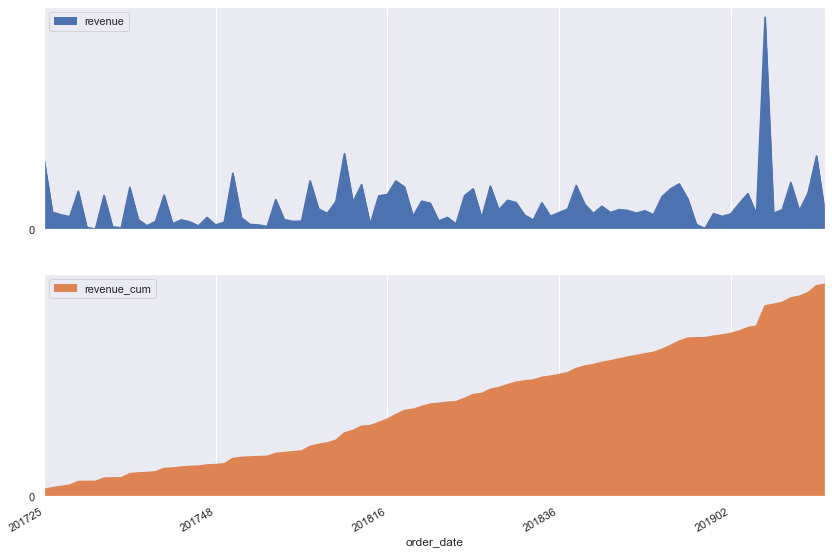

In [7]:
df_week.plot(y=['revenue', 'revenue_cum'], kind='area', subplots=True, figsize=(14,10),
             yticks=[0]);  # Y-axis masked for anonymity

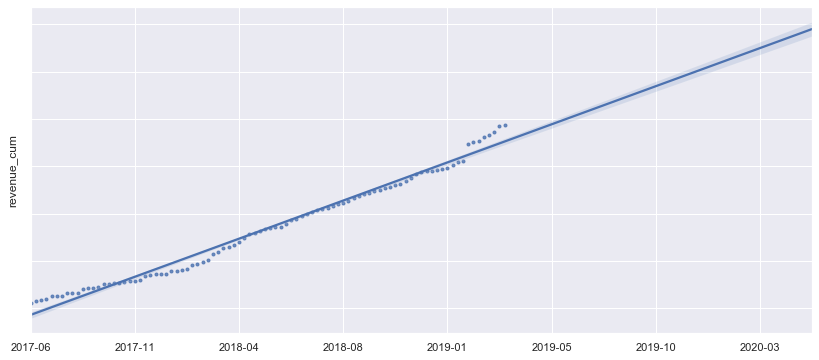

In [8]:
### Fit linear regression on cumulated revenue
fig, ax = plt.subplots(figsize=(14,6))
ax.set_xlim(0, 150)
labels = [d.strftime('%Y-%m') for d in pd.date_range(start='2017-06-21', periods=9, freq='20W')]
ax.set_xticklabels(labels)
ax.set_yticklabels([0]) # Y-axis masked for anonymity
sns.regplot(pd.DataFrame(list(range(len(df_week)))), y = df_week['revenue_cum'], marker=".");

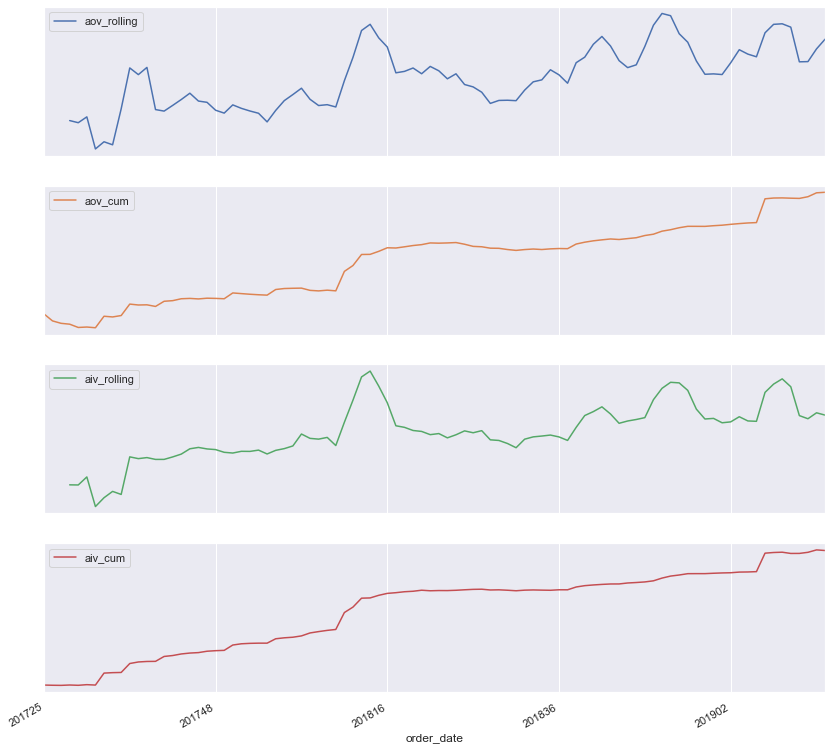

In [9]:
df_week.plot(y=['aov_rolling', 'aov_cum', 'aiv_rolling', 'aiv_cum'], 
             kind='line', subplots=True, figsize=(14, 14),
             yticks=[0]);  # Y-axis masked for anonymity

### Products

In [10]:
df_products = (
    df.loc[:, ['order_date', 'lineitem_name', 'lineitem_quantity', 'lineitem_price', 'total']]
    .rename(columns={'lineitem_quantity': 'qty', 'lineitem_price': 'price'})
    .assign(product=lambda x: (x['lineitem_name'].str.split(' - ')).apply(lambda x: x[0]),
            collection=lambda x: x['product'].str.split().apply(lambda x: x[0]))
    .groupby(['collection', 'product'], as_index=False)
    .agg({'qty': sum, 'price': 'mean', 'total': sum})
    .sort_values('qty', ascending=False)
    .loc[lambda x: x['qty'] >= 5]
    .reset_index(drop=True)
)

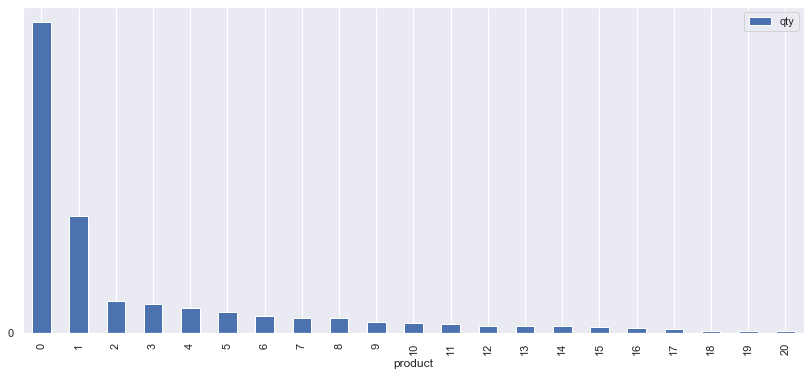

In [11]:
fig, ax = plt.subplots(figsize=(14,6))
df_products.plot(x='product', y='qty', kind='bar', yticks=[0], ax=ax)
ax.set_xticklabels(list(range(0, 21)));

In [12]:
### Evolution of revenue per products collection
df_collections = (
    df
    .assign(collection=lambda x: x['lineitem_name'].str.split().apply(lambda x: x[0]))
    .groupby(['collection', df['order_date'].dt.strftime("%Y%W")])
    .agg({'total': 'sum'})
    .rename(columns={'total': 'revenue'})
    .assign(revenue_cum=lambda x: x['revenue'].cumsum())
    .reset_index()
)
df_collections['revenue_cum'] = df_collections.groupby('collection')['revenue'].transform(pd.Series.cumsum)

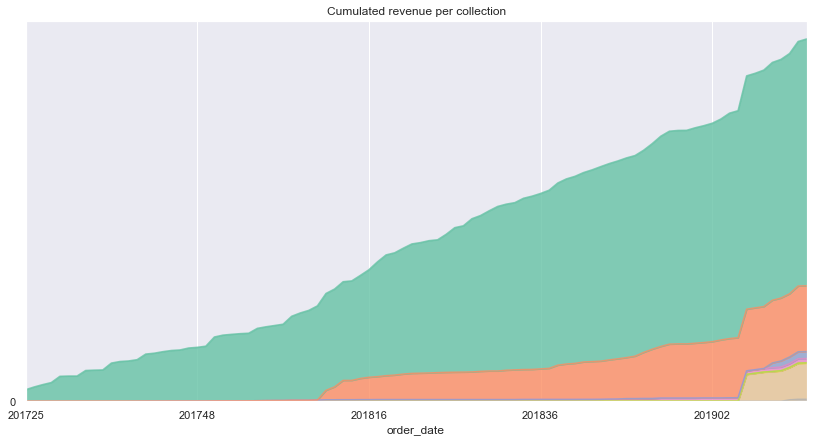

In [13]:
### Plot evolution of revenue per collection
(
    df_collections
    .pivot(index='order_date', columns='collection', values='revenue_cum')
    .fillna(method='ffill', axis=0)
    .plot(kind='area', figsize=(14,7), colormap='Set2_r', alpha=0.8,
          title="Cumulated revenue per collection",
          yticks=[0], legend=False)  # Masked for anonymity
)

### Zip codes

In [14]:
df_zip = (
    df
    .assign(billing_dept=lambda x: 
            df.apply(
                lambda x: (x['billing_country'] \
                           if x['billing_country'] != 'FR' \
                           else (x['billing_country'] + "_" + x['billing_zip'][1:3])), 
                axis=1)
     )
    .groupby(['billing_country', 'billing_dept'], as_index=False)
    .agg({'client_id': 'nunique', 'order_id': 'nunique', 'total': 'sum', 'lineitem_quantity': 'sum'})
    .rename(columns={'client_id': 'clients', 'order_id': 'orders', 'total': 'revenue', 'lineitem_quantity': 'qty'})
    .sort_values('clients', ascending=False)
    .reset_index(drop=True)
    .assign(clients_pct=lambda x: x['clients']/x['clients'].sum(),
            revenue_pct=lambda x: x['revenue']/x['revenue'].sum())
)

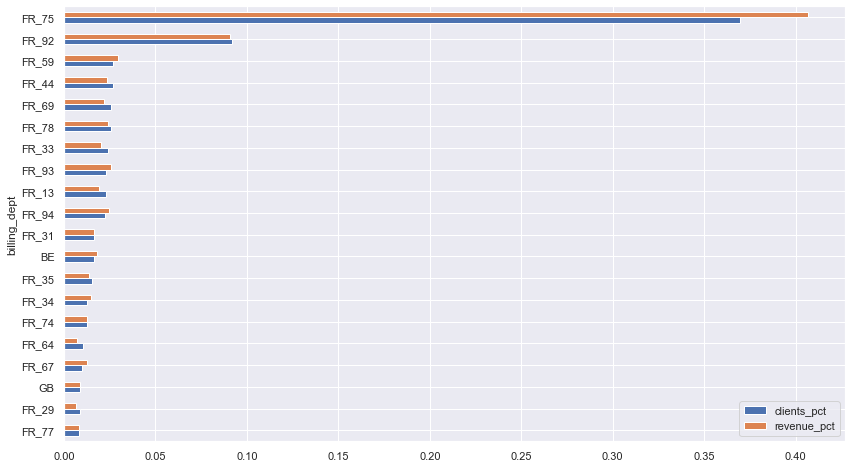

In [15]:
(
    df_zip
    .head(20)
    .sort_values('clients_pct', ascending=True)
    .plot(x='billing_dept', y=['clients_pct', 'revenue_pct'], 
          kind='barh', figsize=(14,8))
)

### Best customers

In [16]:
### Stats per client
df_clients = (
    df
    .groupby('client_id')
    .agg({'total': 'sum', 'order_id': 'nunique', 
          'created_at': {'first': lambda x: x.min(), 
                         'second': lambda x: (x.drop_duplicates().nsmallest(2).iloc[-1] if len(x.drop_duplicates()) > 1 else None), 
                         'latest': 'max'}, 
          'lineitem_quantity': 'sum', 'lineitem_name': 'nunique', 
          'billing_country': lambda x: x.dropna().unique()})
    .sort_values([('total','sum'), ('created_at', 'first')], ascending=[False, True])    
    .reset_index()
)
df_clients.columns = ['client_id', 'revenue', 'orders', 
                      'first_order', 'second_order', 'latest_order',
                      'items_qty', 'unique_items', 'country']
df_clients['aov'] = df_clients['revenue']/df_clients['orders']
df_clients['days_return'] = (df_clients['second_order']-df_clients['first_order']).dt.days

In [17]:
%%capture
df_clients.head()

### New vs returning customers

In [18]:
### Get new and returning client, by date
df_new_clients = (
    # First order date for each client => incremental deduplicated clients
    df_clients.groupby(df_clients['first_order'].dt.date).agg({'orders': 'count'})
    # Second order date => add returning client, substract a new client
    .merge(df_clients.groupby(df_clients['second_order'].dt.date).agg({'orders': 'count'}),
        how='outer', left_index=True, right_index=True)
    .fillna(0)
    .rename(columns={'orders_x': 'unique', 'orders_y': 'returning'})
    .assign(
        unique_cum=lambda x: x['unique'].cumsum(),
        returning_cum=lambda x: x['returning'].cumsum(),    
        new_cum=lambda x: x['unique_cum']-x['returning_cum'],
        new_cum_pct=lambda x: x['new_cum']/x['unique_cum'], 
        returning_cum_pct=lambda x: 1-x['new_cum_pct'] 
    )
)

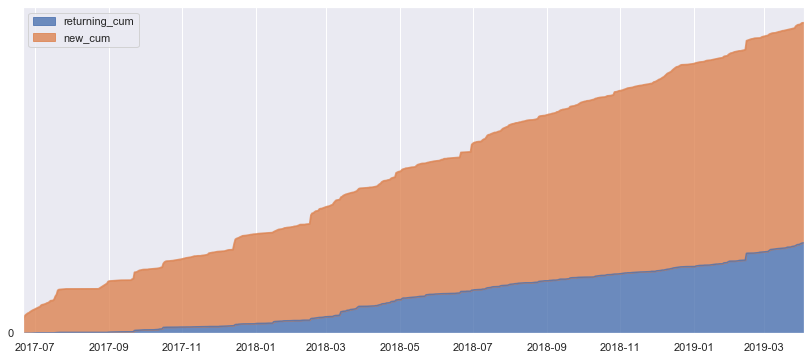

In [19]:
df_new_clients.plot(y=['returning_cum', 'new_cum'], kind='area', alpha=0.8, figsize=(14,6),
                    yticks=[0]);  # Y-axis masked for anonymity

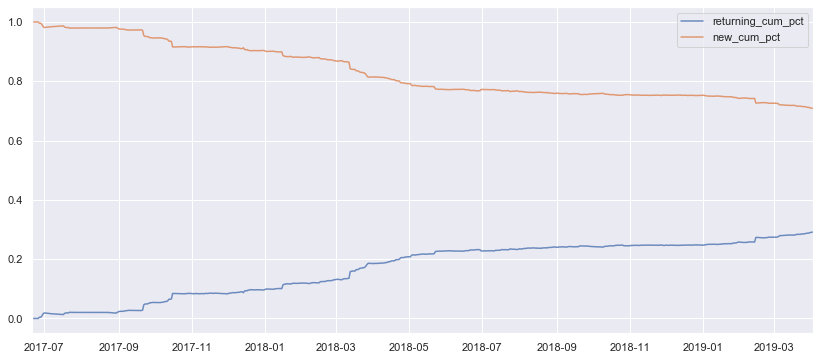

In [20]:
df_new_clients.plot(y=['returning_cum_pct', 'new_cum_pct'], kind='line', alpha=0.8, figsize=(14,6));

### Lag between 1st and 2nd purchase

Average delay: 140.1 days


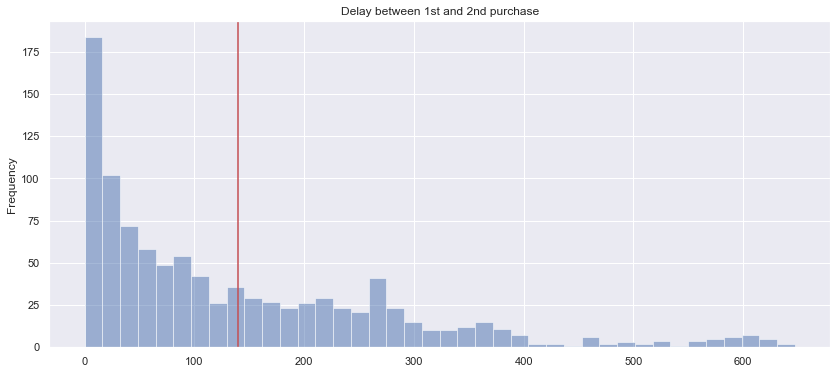

In [21]:
### Plot distribution of delay between 1st and 2nd purchase, for returning customers
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
df_clients['days_return'].plot(kind='hist', bins=40, legend=None, alpha=0.5, ax=ax, 
                               title="Delay between 1st and 2nd purchase")
ax.axvline(df_clients['days_return'].mean(), color='r');
print("Average delay: {:.1f} days".format(df_clients['days_return'].mean()))

### Distribution of revenue and orders per client

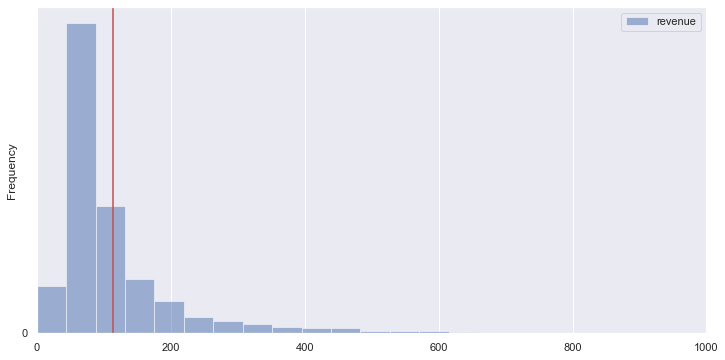

In [22]:
### Revenue per client
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_clients.plot(y='revenue', kind='hist', bins=50, xlim=(0,1000), alpha=0.5, yticks=[0], ax=ax)
ax.axvline(df_clients['revenue'].mean(), color='r')

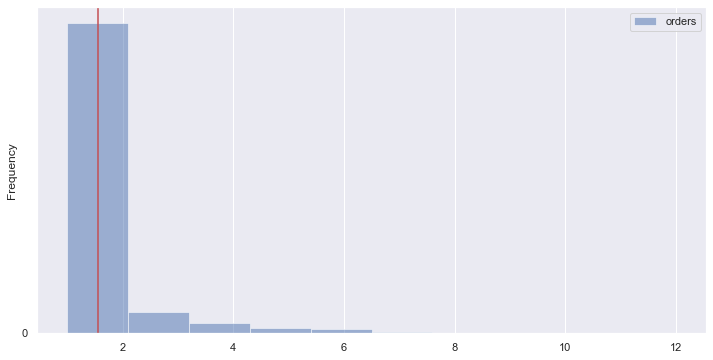

In [23]:
### Orders per client
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
df_clients.plot(y='orders', kind='hist', alpha=0.5, yticks=[0], ax=ax)
ax.axvline(df_clients['orders'].mean(), color='r')

In [24]:
### Table of number of orders per client
(
    df_clients['orders']
    .value_counts()
    .sort_index()
    .to_frame()
    .assign(orders_pct=lambda x: x['orders']/x['orders'].sum(),
            orders_pct_cum=lambda x: x['orders_pct'].cumsum())
    .drop(columns={'orders': 'count'})  # Masked for anonymity
)

,orders_pct,orders_pct_cum
1,0.708735,0.708735
2,0.169734,0.878469
3,0.059305,0.937774
4,0.028046,0.965819
5,0.014023,0.979842
6,0.012562,0.992404
7,0.003214,0.995618
8,0.001753,0.997371
9,0.000584,0.997955
10,0.000584,0.998539


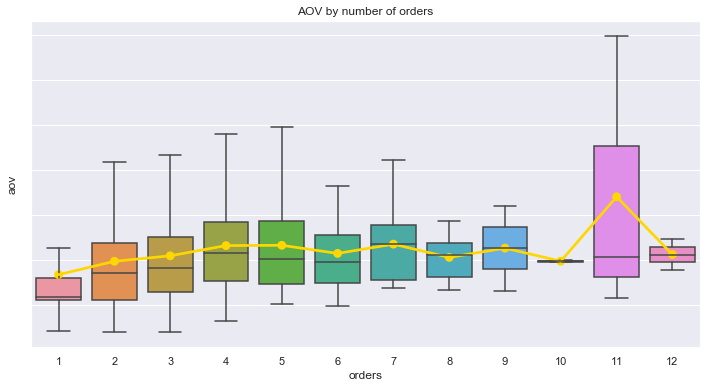

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.boxplot(x=df_clients['orders'], y=df_clients['aov'], 
            showfliers=False, ax=ax)
sns.pointplot(x=df_clients['orders'], y=df_clients['aov'], 
              color='gold', ci=None, ax=ax)
ax.set_title("AOV by number of orders")
ax.set_yticklabels([0]);  # Y-axis masked for anonymity

### Orders per week day and hour of day

In [26]:
### Sales stats per weekday and hour
df_weekday_hour = (
    df
    .groupby([df['created_at'].dt.weekday, df['created_at'].dt.hour])
    .agg({'total': 'sum', 'order_id': 'nunique'})
    .rename(columns={'total': 'revenue', 'order_id': 'orders'})
)

df_weekday_hour.index.names = ['weekday', 'hour']

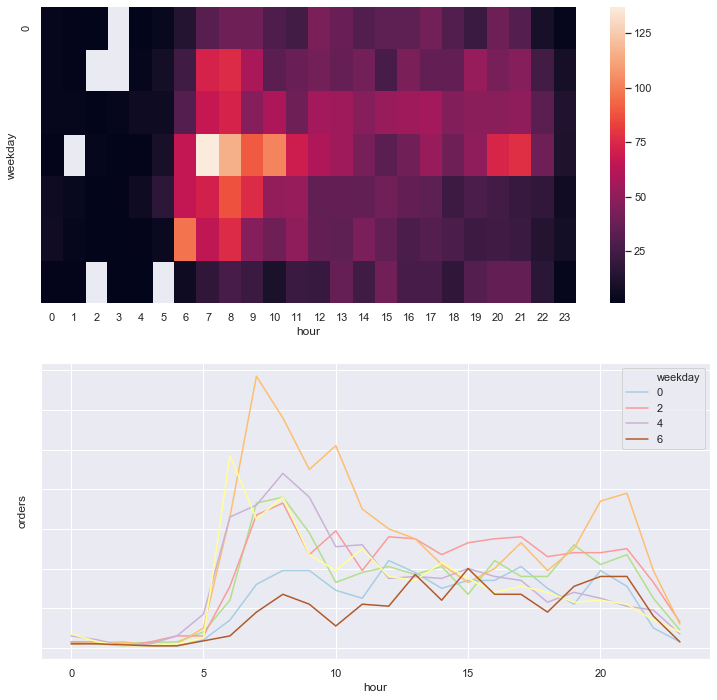

In [27]:
### Plot activity by hour and weekday
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
sns.heatmap(df_weekday_hour['orders'].unstack(), ax=ax[0])
sns.lineplot(x='hour', y='orders', hue='weekday', 
             data=df_weekday_hour.reset_index(), 
             palette='Paired', ax=ax[1])

ax[0].set_yticklabels([0]);  # Y-axis masked for anonymity
ax[1].set_yticklabels([0]);  # Y-axis masked for anonymity

## Lifetime value

### Prepare data

In [28]:
### Get list of transactions, with date, customer ID and monetary value
df_transactions = (
    df
    .groupby(['order_id'])
    .agg({'order_date': 'first', 'client_id': 'first', 'total': 'sum'})
)

In [29]:
### Transform data to appropriate shape
df_rfm = summary_data_from_transaction_data(
    df_transactions, 'client_id', 'order_date', 
    monetary_value_col = 'total',
    observation_period_end='2019-03-31'
)
df_rfm.head(7)

,frequency,recency,T,monetary_value
client_id,,,,
0020c81355c2057,1.0,236.0,619.0,94.5
003b1637ce45163,0.0,0.0,535.0,0.0
00444e8c950c199,0.0,0.0,226.0,0.0
0055eb3281238fa,0.0,0.0,163.0,0.0
006e783513f582e,1.0,103.0,634.0,53.0
007062115a3cbd2,0.0,0.0,299.0,0.0
0085fabd8952f67,2.0,327.0,439.0,94.5


### Simple BG/NBD model

In [30]:
### Fit BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(df_rfm['frequency'], df_rfm['recency'], df_rfm['T'])

<lifetimes.BetaGeoFitter: fitted with 3408 subjects, a: 0.83, alpha: 140.63, b: 3.55, r: 0.30>

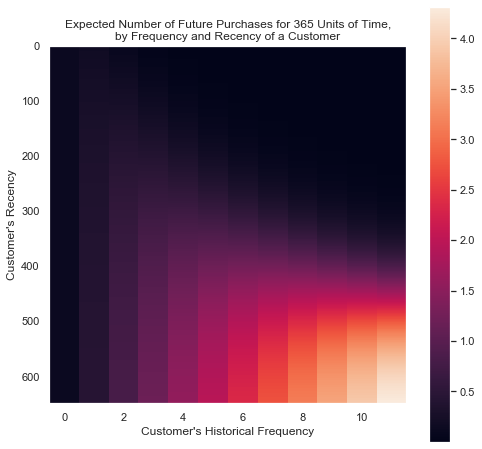

In [31]:
### Expected future purchases given frequency/recency
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax = plot_frequency_recency_matrix(bgf, T=365)
ax.grid(False)

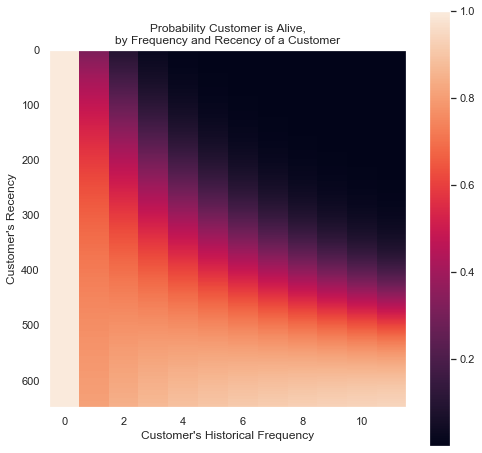

In [32]:
### Probability of being alive given frequency/recency
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax = plot_probability_alive_matrix(bgf)
ax.grid(False)

In [33]:
### Predict expected purchase for every customer

# Number of periods (days) forward to predict the number of purchases
t = 365

# Create prediction dataframe
df_clv = df_rfm.copy()
df_clv['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, df_rfm['frequency'], df_rfm['recency'], df_rfm['T']
)
df_clv['proba_alive'] = bgf.conditional_probability_alive(
    frequency=df_rfm['frequency'],
    recency=df_rfm['recency'],    
    T=df_rfm['T']
)

### Gamma-Gamma model

In [34]:
### Keep only returning customers
df_rfm_return = df_rfm[df_rfm['frequency'] > 0]

### Check (absence of) correlation between frequency and monetary value
df_rfm_return[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.00000,0.02488
monetary_value,0.02488,1.00000


In [35]:
### Fit Gamma-Gamme model
ggf = GammaGammaFitter()
ggf.fit(df_rfm_return['frequency'], df_rfm_return['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 972 subjects, p: 15.67, q: 9.52, v: 44.74>

In [36]:
### Predict expected value per transaction
df_clv['exp_avg_value'] = ggf.conditional_expected_average_profit(
    df_rfm['frequency'], df_rfm['monetary_value']
)

### Compare with actual average profit
df_clv['exp_avg_value'].mean(), df_rfm_return['monetary_value'].mean()

(82.40351077543289, 82.45551248448625)

In [37]:
### Predict residual Customer Lifetime Value
df_clv['clv'] = ggf.customer_lifetime_value(
    bgf, # predict the number of future transactions
    df_rfm['frequency'],
    df_rfm['recency'],
    df_rfm['T'],
    df_rfm['monetary_value'],
    time=12, # months
    discount_rate=0.01 # to be calculated for better estimation
)

In [38]:
df_clv.head(10)

,frequency,recency,T,monetary_value,predicted_purchases,proba_alive,exp_avg_value,clv
client_id,,,,,,,,
0020c81355c2057,1.0,236.0,619.0,94.5,0.366296,0.632351,90.224048,30.646868
003b1637ce45163,0.0,0.0,535.0,0.0,0.153738,1.000000,82.353889,11.734557
00444e8c950c199,0.0,0.0,226.0,0.0,0.271200,1.000000,82.353889,20.726374
0055eb3281238fa,0.0,0.0,163.0,0.0,0.321570,1.000000,82.353889,24.588284
006e783513f582e,1.0,103.0,634.0,53.0,0.277238,0.487392,63.333827,16.281799
007062115a3cbd2,0.0,0.0,299.0,0.0,0.229641,1.000000,82.353889,17.542679
0085fabd8952f67,2.0,327.0,439.0,94.5,0.992625,0.770313,91.905301,84.700322
00ea24e5e4d8e23,0.0,0.0,531.0,0.0,0.154603,1.000000,82.353889,11.800679
00eadbac352d329,0.0,0.0,533.0,0.0,0.154169,1.000000,82.353889,11.767525


## RFM segmentation

In [39]:
### Compute recency: number of days since last purchase
df_clients['recency'] = (
    df_clients
    .apply(
        lambda x: (df_clients['latest_order'].max() - x['latest_order']).days, 
        axis=1)
)

In [40]:
### Compute quantiles
df_clients['r'] = pd.qcut(df_clients['recency'], 4, labels=[3,2,1,0]).astype(int)
df_clients['f'] = pd.qcut(df_clients['orders'], 10, labels=False, duplicates='drop')
df_clients['m'] = pd.qcut(df_clients['revenue'], 4, labels=False)

### Aggregate RFM values with INVERSE value (bigger is better)
df_clients['rfm'] = df_clients['r'] * 100 + df_clients['f'] * 10 + df_clients['m']

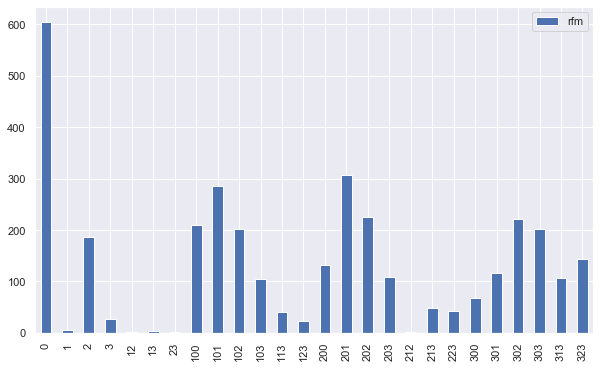

In [41]:
### Plot distribution
(
    df_clients['rfm']
    .value_counts()
    .sort_index()
    .to_frame()
    .plot(kind='bar', figsize=(10,6))
)

### K-means segmentation

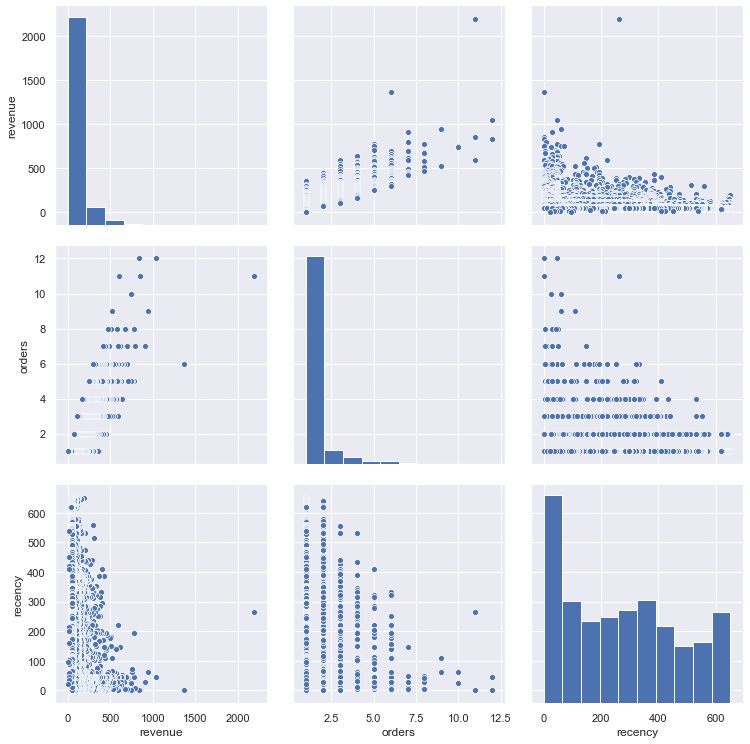

In [42]:
### Look at pairplot for RFM
sns.pairplot(df_clients[['revenue', 'orders', 'recency']], height=3.5)

In [43]:
### Create clusters based on Recency, Frequency, Monetary value
kmeans = KMeans(n_clusters=3)
df_clients['rfm_cluster'] = kmeans.fit_predict(df_clients[['revenue', 'orders', 'recency']])

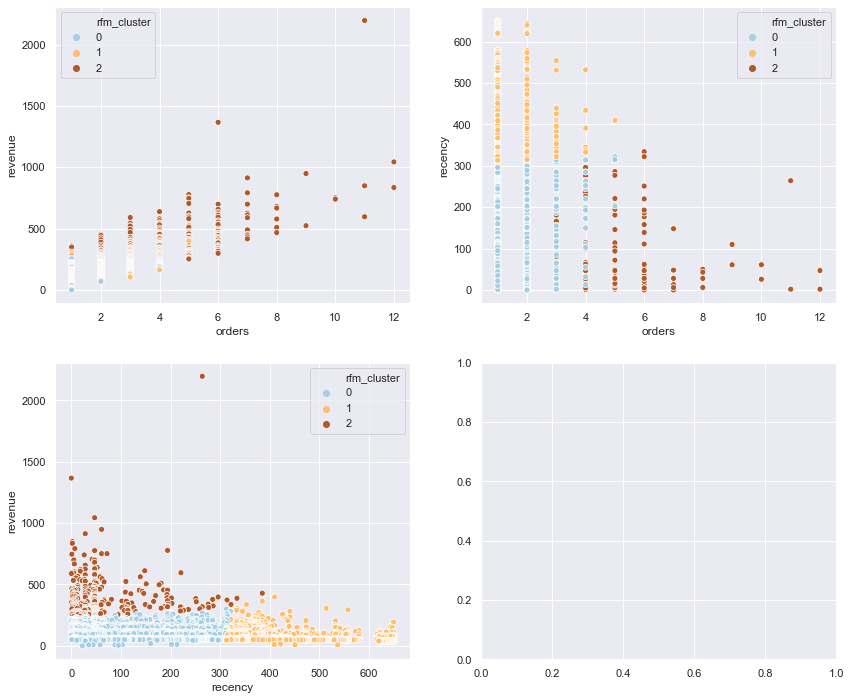

In [44]:
### Plot results
fig, ax = plt.subplots(2, 2, figsize=(14,12))
sns.scatterplot(x='orders', y='revenue', hue='rfm_cluster', data=df_clients, palette='Paired', ax=ax[0,0])
sns.scatterplot(x='orders', y='recency', hue='rfm_cluster', data=df_clients, palette='Paired', ax=ax[0,1])
sns.scatterplot(x='recency', y='revenue', hue='rfm_cluster', data=df_clients, palette='Paired', ax=ax[1,0])